# Import libs

In [20]:
import scipy.io as sio
from skimage.metrics import peak_signal_noise_ratio

from models import *
from utils.denoising_utils import *

print('import success...')

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
data_type = torch.cuda.FloatTensor

sigma = 100
sigma_ = sigma / 255.

import success...


# Load image

In [21]:
file_name = 'data/denoising/denoising.mat'
# ensure dimensions [0][1] are divisible by 32 (or 2^depth)!

mat = sio.loadmat(file_name)
img_np = mat["image"]
# img_np = img_np.transpose(2,0,1)
img_var = torch.from_numpy(img_np).type(data_type)
img_noisy_np = get_noisy_image(img_np, sigma_)
img_noisy_var = torch.from_numpy(img_noisy_np).type(data_type)
#img_noisy_np = mat["image_noisy"]
#img_noisy_np = img_noisy_np.transpose(2,0,1)
#img_noisy_var = torch.from_numpy(img_noisy_np).type(dtype)

print(img_var.shape)
print(img_noisy_var.shape)

torch.Size([191, 200, 200])
torch.Size([191, 200, 200])


### Visualize

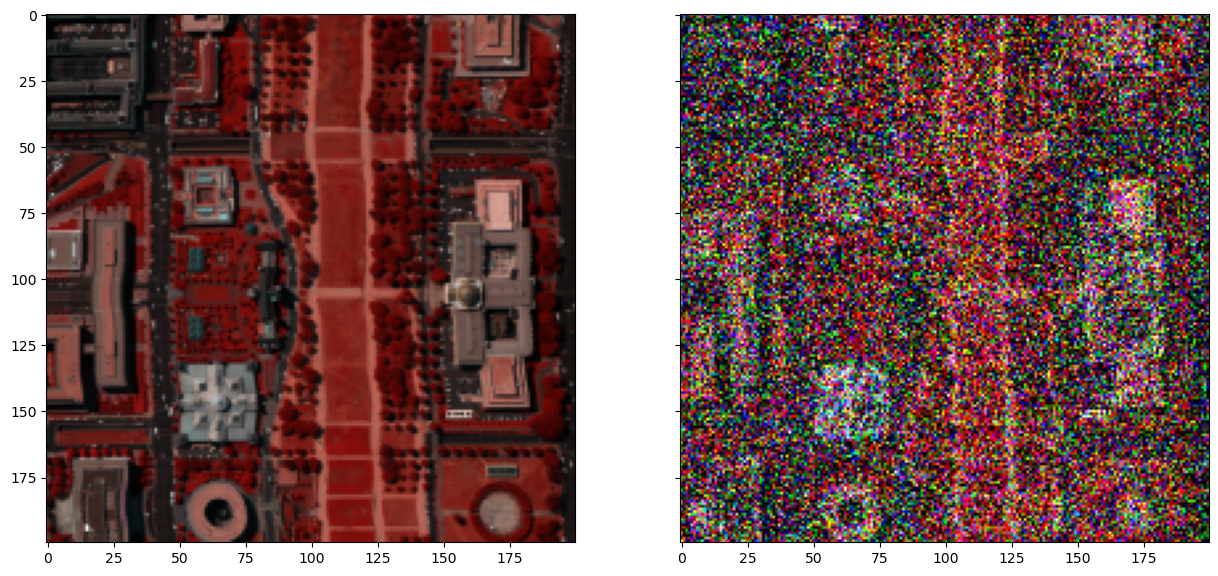

In [22]:
from matplotlib import pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 15))
ax1.imshow(torch.stack((img_var[56, :, :], img_var[26, :, :], img_var[16, :, :]), 2).cpu())
ax2.imshow(torch.stack((img_noisy_var[56, :, :], img_noisy_var[26, :, :], img_noisy_var[16, :, :]), 2).cpu())
plt.show()

# Setup

In [18]:
method = '2D'
pad = 'reflection'
OPT_OVER = 'net'  # 'net,input'

reg_noise_std = 0.03  # 0 0.01 0.05 0.08
LR = 0.01

OPTIMIZER = 'adam'  # 'LBFGS'
exp_weight = 0.99

show_every = 200
save_every = 200

num_iter = 1801
input_depth = img_np.shape[0]

net = skip(input_depth, img_np.shape[0],
           num_channels_down=[128] * 5,
           num_channels_up=[128] * 5,
           num_channels_skip=[4] * 5,
           filter_size_up=3, filter_size_down=3, filter_skip_size=1,
           upsample_mode='bilinear',  # downsample_mode='avg',
           need1x1_up=False,
           need_sigmoid=False, need_bias=True, pad=pad, act_fun='LeakyReLU').type(data_type)

net_input = get_noise(input_depth, method, (img_np.shape[1], img_np.shape[2])).type(data_type).detach()

# Compute number of parameters
s = sum([np.prod(list(p.size())) for p in net.parameters()])
print('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(data_type)

img_noisy_var = img_noisy_var[None, :].cuda()

Number of params: 2342047


# Optimize

In [ ]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0

i = 0

print(net)

Starting optimization with ADAM
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


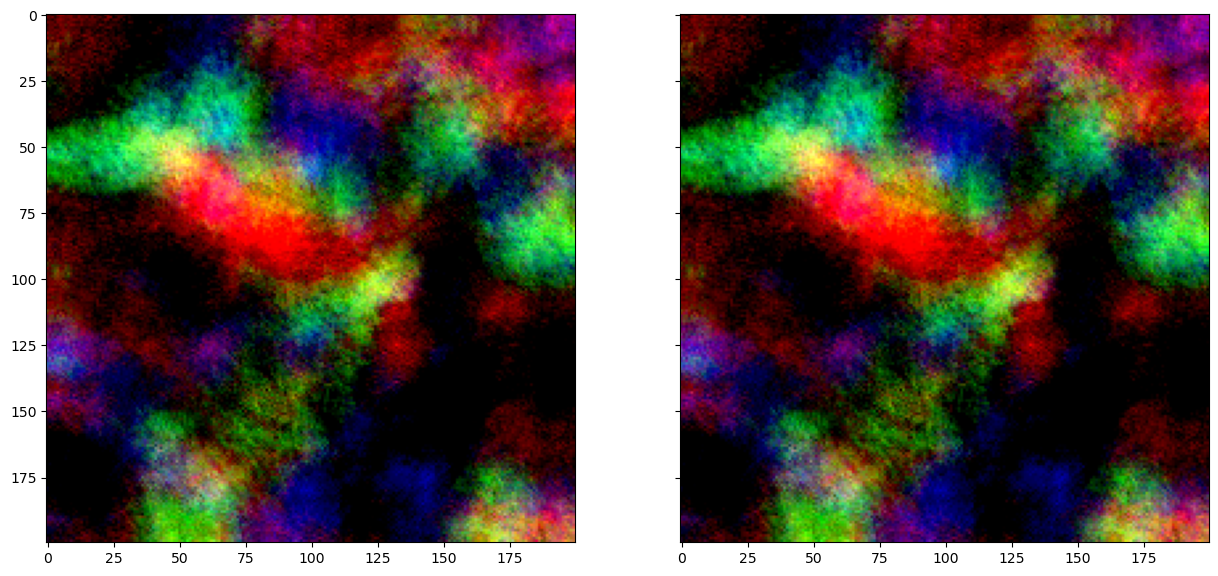

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>8487 PSNR_gt_sm: 10.511035 
<class 'numpy.ndarray'> <class 'numpy.ndarray'>9644 PSNR_gt_sm: 10.537225 
<class 'numpy.ndarray'> <class 'numpy.ndarray'>1916 PSNR_gt_sm: 10.567490 
<class 'numpy.ndarray'> <class 'numpy.ndarray'>37913 PSNR_gt_sm: 10.599831 
<class 'numpy.ndarray'> <class 'numpy.ndarray'>96476 PSNR_gt_sm: 10.634168 
<class 'numpy.ndarray'> <class 'numpy.ndarray'>61486 PSNR_gt_sm: 10.669454 
<class 'numpy.ndarray'> <class 'numpy.ndarray'>09563 PSNR_gt_sm: 10.704100 
<class 'numpy.ndarray'> <class 'numpy.ndarray'>13497 PSNR_gt_sm: 10.737423 
<class 'numpy.ndarray'> <class 'numpy.ndarray'>27443 PSNR_gt_sm: 10.769140 
<class 'numpy.ndarray'> <class 'numpy.ndarray'>46826 PSNR_gt_sm: 10.799528 
<class 'numpy.ndarray'> <class 'numpy.ndarray'>32521 PSNR_gt_sm: 10.828882 
<class 'numpy.ndarray'> <class 'numpy.ndarray'>52714 PSNR_gt_sm: 10.857614 
<class 'numpy.ndarray'> <class 'numpy.ndarr

KeyboardInterrupt: 

In [19]:


def closure():
    global i, out_avg, psrn_noisy_last, last_net, net_input

    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out = net(net_input)

    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)

    total_loss = mse(out, img_noisy_var)
    total_loss.backward()

    out_np = out.detach().cpu().squeeze().numpy()
    out_avg_np = out_avg.detach().cpu().squeeze().numpy()

    psrn_noisy = peak_signal_noise_ratio(img_noisy_np.astype(np.float32), np.clip(out_np, 0, 1))
    psrn_gt = peak_signal_noise_ratio(img_np.astype(np.float32), np.clip(out_np, 0, 1))
    psrn_gt_sm = peak_signal_noise_ratio(img_np.astype(np.float32), np.clip(out_avg_np, 0, 1))

    print('Iteration %05d    Loss %f  PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_gt, psrn_gt_sm), '\r',
          end='')
    if i % show_every == 0:
        out_np = np.clip(out_np, 0, 1)
        out_avg_np = np.clip(out_avg_np, 0, 1)

        f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 15))
        ax1.imshow(np.stack((out_np[56, :, :], out_np[26, :, :], out_np[16, :, :]), 2))
        ax2.imshow(np.stack((out_avg_np[56, :, :], out_avg_np[26, :, :], out_avg_np[16, :, :]), 2))
        plt.show()

    if i % save_every == 0:
        sio.savemat("results/result_denoising_2D_it%05d.mat" % i, {'pred': out_np.transpose(1, 2, 0),
                                                                     'pred_avg': out_avg_np.transpose(1, 2, 0)})

    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5:
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.detach().copy_(new_param.cuda())

            return total_loss * 0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy

    i += 1

    return total_loss


p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)